# Midterm 1

![](https://github.com/wecacuee/ECE417-F24-Mobile-Robots/blob/master/docs/notebooks/mt1/imgs/umaine.png?raw=1)

You are given the map of UMaine as an image that contains only the following colors:
1. Green for grass
2. Purple/Red for buildings
3. Gray for parking lots and assigned roads and pathways
4. White for everything else.

As a take home midterm you have to find (a) the shortest distance path (b) the shortest time path from Collins art center (`start=[559, 1226]`) to the Lord Hall(`goal=[895, 203]`).

Assume the following:

1. The robot moves with half the speed in the grass.
2. The robot cannot move through purple/red buildings area
3. Gray and white areas are equivalent
4. Each pixel in the image is 1/3rd of a meter in distance. The robot moves at 10m/sec

#### Getting the image
The following code gets the image for you

In [32]:
FILELOCATION = "umaine.png"
import urllib
with urllib.request.urlopen("https://raw.githubusercontent.com/wecacuee/gazebo_osm/1e7f7a5bfed1e9a1bd60848bbf15d16fc4b1ccbf/testFiles/umaine.png") as uf:
    with open("umaine.png", "wb") as wf:
        wf.write(uf.read())


In [ ]:
!pip install ipympl matplotlib numpy

#### Exploring the image
The following code allows you to explore the image

Textarea(value='You have not clicked on the figure yet', description='Color:  ', placeholder='You have not cli…

15

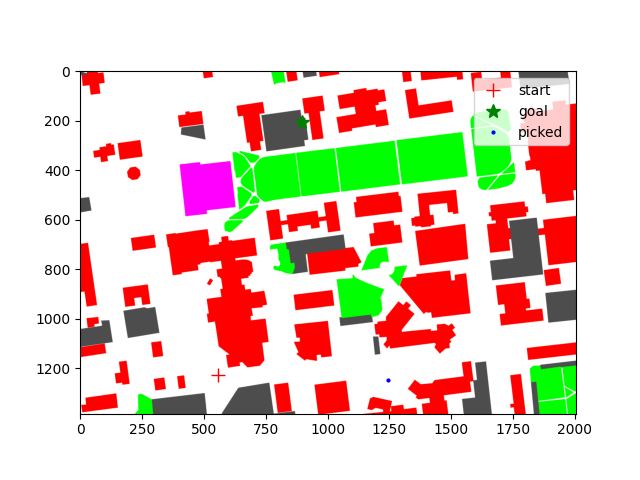

In [29]:
# Click anywere on the image to find the color of that point
import ipywidgets as widgets # Make the print statement interactive
import matplotlib.pyplot as plt
import numpy as np
# Make the matplotlib figure interactive
%matplotlib widget
start = np.array([559, 1226], dtype=int)
goal = np.array([895, 203], dtype=int)
img = plt.imread('umaine.png')
random_pt = np.random.randint(2, (img.shape[1], img.shape[0]))
# Let's plot this point
def plot_map(ax, img, goal, start):
    ax.imshow(img) # Plot the image again
    ax.plot(start[0], start[1], 'r+', markersize=10, label='start')
    ax.plot(goal[0], goal[1], 'g*', markersize=10, label='goal')
    ax.legend()
    return ax
# Draw the map
fig, ax = plt.subplots()
plot_map(ax, img, goal, start)
picked_pt, = ax.plot(random_pt[0], random_pt[1], 'bo', markersize=2, label='picked')
ax.legend()

# Create a textarea to display the interactive message
txtwidget = widgets.Textarea(
    value='You have not clicked on the figure yet',
    placeholder='You have not clicked on the figure yet',
    description='Color:  ',
    disabled=False,
    width=200
)
display(txtwidget)

# This function will be called whenever you click anywhere on the map
def onclick(event):
    x, y = event.xdata, event.ydata
    picked_pt.set_xdata([x])
    picked_pt.set_ydata([y])
    # Change the display message in the figure
    txtwidget.value = "(%d, %d): %.1f %.1f %.1f %.1f" % tuple((int(x), int(y), *img[int(y), int(x), :]))

fig.canvas.mpl_connect('button_release_event', onclick)


### Categorizing the image by color

The following code categorizes the image into

True

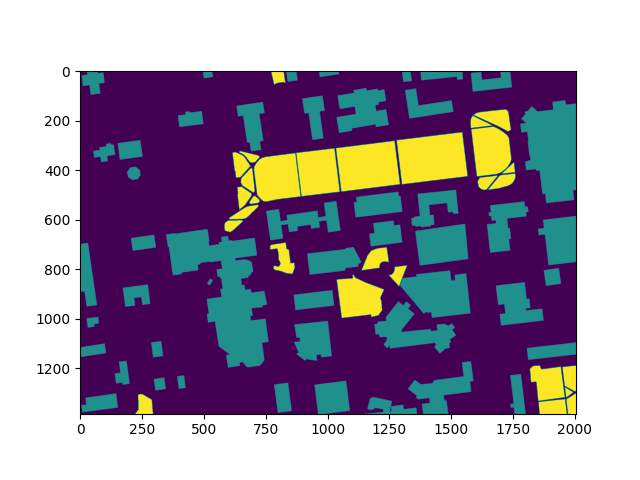

In [30]:
BUILDING_CODE=1
BUILDING_COLOR=[1, 0, 0, 1]

GRASS_COLOR=[0, 1, 0, 1]
GRASS_CODE=2

OTHER_CODE=0
def color_to_category_img(img):
    """Converts the color image into category image"""
    return np.where(np.all(np.abs(img - BUILDING_COLOR) < 0.05, axis=2),
             BUILDING_CODE,
             np.where(
                 np.all(np.abs(img - GRASS_COLOR) < 0.05, axis=2),
                 GRASS_CODE,
                 OTHER_CODE))
category_img = color_to_category_img(img)
fig, ax = plt.subplots()
ax.imshow(category_img)

def find_point_category(category_img, pt):
    """Find the category of the point"""
    return category_img[pt[1], pt[0]]

find_point_category(category_img, [959, 413]) == GRASS_CODE

In [31]:
find_point_category(category_img, [627, 1070]) == BUILDING_CODE

True

In [33]:
find_point_category(category_img, [583, 108]) == OTHER_CODE

True

In [31]:
class Node:
    def __init__(self, position: Tuple[int, int], g_cost: float = float('inf'),
                 h_cost: float = 0, parent = None):
        self.position = position
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost
        self.parent = parent

    def __lt__(self, other):
        return self.f_cost < other.f_cost

def get_neighbors(current_pos: Tuple[int, int], category_img: np.ndarray) -> List[Tuple[int, int]]:
    height, width = category_img.shape
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            new_x = current_pos[0] + dx
            new_y = current_pos[1] + dy
            if 0 <= new_x < width and 0 <= new_y < height:
                if category_img[new_y, new_x] != BUILDING_CODE:
                    neighbors.append((new_x, new_y))
    return neighbors

def manhattan_distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def get_movement_cost(current_pos: Tuple[int, int], next_pos: Tuple[int, int],
                     category_img: np.ndarray, time_based: bool = False) -> float:
    distance = np.sqrt((next_pos[0] - current_pos[0])**2 +
                      (next_pos[1] - current_pos[1])**2) / 3.0

    if not time_based:
        return distance

    if category_img[next_pos[1], next_pos[0]] == GRASS_CODE:
        return distance / 5.0
    else:
        return distance / 10.0

In [ ]:
def astar(start: Tuple[int, int], goal: Tuple[int, int],
          category_img: np.ndarray, time_based: bool = False) -> Tuple[List[Tuple[int, int]], Set[Tuple[int, int]]]:
    """A* pathfinding algorithm that also returns the explored nodes."""
    start_node = Node(start, g_cost=0, h_cost=manhattan_distance(start, goal))
    open_set = [start_node]
    closed_set: Set[Tuple[int, int]] = set()
    nodes: Dict[Tuple[int, int], Node] = {start: start_node}
    explored_nodes = set()

    while open_set:
        current = heappop(open_set)
        explored_nodes.add(current.position)

        if current.position == goal:
            path = []
            while current:
                path.append(current.position)
                current = current.parent
            return path[::-1], explored_nodes

        closed_set.add(current.position)

        for neighbor_pos in get_neighbors(current.position, category_img):
            if neighbor_pos in closed_set:
                continue

            movement_cost = get_movement_cost(current.position, neighbor_pos,
                                           category_img, time_based)
            tentative_g_cost = current.g_cost + movement_cost

            if neighbor_pos not in nodes:
                neighbor = Node(neighbor_pos)
                nodes[neighbor_pos] = neighbor
            else:
                neighbor = nodes[neighbor_pos]

            if tentative_g_cost >= neighbor.g_cost:
                continue

            neighbor.parent = current
            neighbor.g_cost = tentative_g_cost
            neighbor.h_cost = manhattan_distance(neighbor_pos, goal)
            neighbor.f_cost = neighbor.g_cost + neighbor.h_cost

            if neighbor_pos not in [n.position for n in open_set]:
                heappush(open_set, neighbor)

    return [], explored_nodes

In [ ]:
def plot_path_with_exploration(path: List[Tuple[int, int]], explored: Set[Tuple[int, int]],
                             img: np.ndarray, start: Tuple[int, int], goal: Tuple[int, int],
                             title: str, show_costs: bool = True):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the base map
    ax.imshow(img)

    # Plot explored nodes
    explored = np.array(list(explored))
    if len(explored) > 0:
        ax.scatter(explored[:, 0], explored[:, 1], color='yellow', alpha=0.1,
                  label=f'Explored Nodes ({len(explored)})')

    # Plot the path
    if path:
        path = np.array(path)
        ax.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, label='Path')

    # Plot start and goal
    ax.plot(start[0], start[1], 'r+', markersize=15, label='Start')
    ax.plot(goal[0], goal[1], 'g*', markersize=15, label='Goal')

    # Calculate and display metrics
    if path:
        total_distance = sum(get_movement_cost(path[i], path[i+1], category_img, False)
                           for i in range(len(path)-1))
        total_time = sum(get_movement_cost(path[i], path[i+1], category_img, True)
                        for i in range(len(path)-1))
        metrics_text = f'Total Distance: {total_distance:.2f}m\nTotal Time: {total_time:.2f}s'
        ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

    ax.set_title(f'{title}\nExplored {len(explored)} nodes to find optimal path')
    ax.legend()
    plt.show()

In [ ]:
# Run the pathfinding
start_point = tuple(start)
goal_point = tuple(goal)

print("Finding shortest distance path...")
t0 = time.time()
distance_path, distance_explored = astar(start_point, goal_point, category_img, time_based=False)
t1 = time.time()
print(f"Found path in {t1-t0:.3f} seconds")

print("\nFinding shortest time path...")
t0 = time.time()
time_path, time_explored = astar(start_point, goal_point, category_img, time_based=True)
t1 = time.time()
print(f"Found path in {t1-t0:.3f} seconds")

# Visualize both paths with exploration areas
plot_path_with_exploration(distance_path, distance_explored, img,
                         start_point, goal_point, "Shortest Distance Path")
plot_path_with_exploration(time_path, time_explored, img,
                         start_point, goal_point, "Shortest Time Path")